## D5d. MODIS Balanced dataset 200 2013 - 2019 - Model training and validation:
This model will use data obtained from MODIS (one day only), NDWI, NDWI_ICE, DEM SLOPE and EUCLIDEAN_NORM to predict water and non-water features. For all years

#### 0. Load required libraries, site dependant constants and utility functions.

In [1]:
from os import listdir
from os.path import isfile, join
from lightgbm.sklearn import LGBMClassifier
import numpy as np
import seaborn as sns
import datetime
from sklearn import metrics
import joblib
# EOLearn libraries:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, LoadTask, SaveTask, FeatureType, EOExecutor
from eolearn.core import OverwritePermission

# Add to python path parent dictionary
import sys
sys.path.append("../../")

# load site dependant constants (HERE YOU CAN CHOOSE DIFFERENT LOCATION)
from aoi_sites import upe_promice_area as site

# load utility functions
from utils import io_functions as io_utils
from utils import plot_functions as plot_utils

In [2]:
# pick dataset_name
input_dataset_file_name = '_sptl_smpl_200_pr_patch_blanced_0_1_min_5_ver_1/'

#### 1. Load sampled eopatches:

In [8]:
dataset_filepath_2013 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10{}'.format(input_dataset_file_name)
dataset_filepath_2014 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2014_05-2014_10{}'.format(input_dataset_file_name)
dataset_filepath_2015 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2015_05-2015_10{}'.format(input_dataset_file_name)
dataset_filepath_2016 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2016_05-2016_10{}'.format(input_dataset_file_name)
dataset_filepath_2017 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2017_05-2017_10{}'.format(input_dataset_file_name)
dataset_filepath_2018 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2018_05-2018_10{}'.format(input_dataset_file_name)
dataset_filepath_2019 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10{}'.format(input_dataset_file_name)

dataset_path_list = [dataset_filepath_2013,
                dataset_filepath_2014,
                dataset_filepath_2015,
                dataset_filepath_2016,
                dataset_filepath_2017,
                dataset_filepath_2018,
                dataset_filepath_2019]

#### 2. Choose test eopatches

In [13]:
list_of_available_patches_2013 = io_utils.get_list_of_eopatches(dataset_filepath_2013)

test_eppatches_chosen_names = np.random.choice(list_of_available_patches_2013, 5, replace=False)
test_eppatches_chosen_names

array(['2978_maxcc_0.05_x-3_y-139', '3062_maxcc_0.05_x-4_y-133',
       '3067_maxcc_0.05_x-4_y-138', '3473_maxcc_0.05_x-7_y-134',
       '2977_maxcc_0.05_x-3_y-138'], dtype='<U25')

In [18]:
%%time
train_eopatches= []
test_eopatches= []
train_eopatches_filenames = []

for eopatches_filepath in dataset_path_list:

    list_of_available_patches = io_utils.get_list_of_eopatches(eopatches_filepath)
    list_in_chunks = io_utils.chunkIt(list_of_available_patches, 2 ) # number of chunks- 1 bc all can go
    for chunk in list_in_chunks:
        #print('Doing now following eopatches:', chunk )
        for eopatch_name in chunk:
            if eopatch_name in test_eppatches_chosen_names:
                test_eopatches.append(EOPatch.load(eopatches_filepath+eopatch_name, lazy_loading=True))
            else:
                train_eopatches_filenames.append(eopatches_filepath+eopatch_name)
                train_eopatches.append(EOPatch.load(eopatches_filepath+eopatch_name, lazy_loading=True))    
print(len(train_eopatches))
print(len(test_eopatches))

254
30
Wall time: 354 ms


In [43]:
# check if all eopatches from all years are there. 
train_eopatches_filenames

[EOPatch(
   data: {
     DATASET_CLD_200_dil_6_str2_SAMPLED: numpy.ndarray(shape=(2, 200, 1, 11), dtype=float32)
   }
   mask: {
     WATER_MASK_ST_025_SAMPLED: numpy.ndarray(shape=(2, 200, 1, 1), dtype=bool)
   }
   scalar: {}
   label: {}
   vector: {}
   data_timeless: {}
   mask_timeless: {}
   scalar_timeless: {}
   label_timeless: {}
   vector_timeless: {}
   meta_info: {
     DEM_RAW_AVG: 798.2763
     DEM_RAW_MAX: 999.0
     DEM_RAW_MED: 806.0
     DEM_RAW_MIN: 555.0
     DEM_RAW_STD: 101.6355
     DEM_RAW_VAR: 10329.774
     index_x: 3
     index_y: 138
     maxcc: '0.05'
     patch_index: 2977
     service_type: 'wcs'
     site_name: 'UPE_PROMICE'
     size_x: '30m'
     size_y: '30m'
     time_difference: datetime.timedelta(seconds=7200)
     time_interval: ('2013-05-01', '2013-10-31')
   }
   bbox: BBox(((400000.0, 8110000.0), (410000.0, 8120000.0)), crs=EPSG:32622)
   timestamp: [datetime.datetime(2013, 9, 19, 15, 44, 37), datetime.datetime(2013, 9, 28, 15, 38, 22)]
 ), E

In [19]:
eo_patch = io_utils.load_exemplary_eopatch_from_file(file ='../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10{}'.format(input_dataset_file_name))
eo_patch

Loaded from ../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10_sptl_smpl_200_pr_patch_blanced_0_1_min_5_ver_1/3312_maxcc_0.05_x-6_y-136


EOPatch(
  data: {
    DATASET_CLD_200_dil_6_str2_SAMPLED: numpy.ndarray(shape=(23, 200, 1, 11), dtype=float32)
  }
  mask: {
    WATER_MASK_ST_025_SAMPLED: numpy.ndarray(shape=(23, 200, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    DEM_RAW_AVG: 1332.9497
    DEM_RAW_MAX: 1429.0
    DEM_RAW_MED: 1334.0
    DEM_RAW_MIN: 1218.0
    DEM_RAW_STD: 45.98734
    DEM_RAW_VAR: 2114.8354
    index_x: 6
    index_y: 136
    maxcc: '0.05'
    patch_index: 3312
    service_type: 'wcs'
    site_name: 'UPE_PROMICE'
    size_x: '30m'
    size_y: '30m'
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2019-05-01', '2019-10-31')
  }
  bbox: BBox(((430000.0, 8090000.0), (440000.0, 8100000.0)), crs=EPSG:32622)
  timestamp: [datetime.datetime(2019, 5, 1, 15, 30, 8), ..., datetime.datetime(2019, 10, 1, 15, 24, 53)], length=23
)

#### 2. 80 /20 cross validation # later, leave one out, just from trains, 

In [14]:
#import random
#index_list = [i for i in range(0,len(eopatches))]
#random.shuffle(index_list)

#no_of_eo_patches_to_test = 5
#train_ID = []
##test_ID = []
#for x in range(5):
#    test_ID.append(index_list.pop())
#test_ID = np.sort(test_ID)[::-1]
#train_ID = index_list

In [15]:
#print('Test indexes:', test_ID)
#print('Train indexes:', train_ID)

Test indexes: [256 172 135 101  99]
Train indexes: [167, 283, 155, 154, 270, 56, 71, 116, 212, 51, 252, 16, 237, 98, 160, 262, 277, 213, 17, 33, 271, 275, 35, 44, 79, 195, 186, 54, 169, 145, 279, 112, 217, 36, 245, 257, 157, 247, 210, 92, 194, 183, 205, 2, 40, 93, 65, 207, 85, 282, 42, 4, 240, 80, 91, 82, 72, 164, 214, 37, 23, 12, 281, 38, 68, 171, 50, 239, 137, 260, 258, 280, 253, 244, 130, 250, 58, 147, 83, 19, 107, 255, 202, 84, 133, 269, 30, 7, 143, 158, 242, 224, 125, 272, 128, 115, 60, 39, 259, 43, 234, 215, 100, 206, 216, 6, 27, 263, 248, 136, 276, 11, 176, 218, 230, 146, 273, 170, 236, 189, 47, 173, 227, 89, 174, 184, 32, 264, 266, 69, 190, 18, 64, 21, 110, 175, 104, 15, 59, 211, 119, 129, 235, 201, 278, 221, 73, 114, 249, 88, 179, 14, 34, 232, 243, 86, 226, 5, 20, 203, 1, 181, 222, 185, 191, 74, 10, 49, 233, 132, 96, 141, 150, 219, 261, 66, 148, 204, 95, 251, 105, 102, 118, 199, 55, 52, 62, 152, 53, 90, 196, 149, 87, 153, 187, 182, 108, 48, 231, 70, 166, 75, 57, 77, 165, 46, 1

In [16]:
#test_eopatches = []
#
#for i in test_ID:
#    test_eopatches.append( eopatches.pop(i))
#train_eopatches = eopatches
#del eopatches

####  3. Fetch and organise set

In [20]:
# Definition of the train and test patch IDs

# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['DATASET_CLD_200_dil_6_str2_SAMPLED'] for eopatch in train_eopatches if eopatch.data['DATASET_CLD_200_dil_6_str2_SAMPLED'].size > 0])
#features_train (number_of_patches,(time,width,height, bands))
labels_train = np.array([eopatch.mask['WATER_MASK_ST_025_SAMPLED'] for eopatch in train_eopatches if eopatch.mask['WATER_MASK_ST_025_SAMPLED'].size > 0])
#features_train (number_of_patches,(time,width,height, answer=True, False))
features_test = np.array([eopatch.data['DATASET_CLD_200_dil_6_str2_SAMPLED'] for eopatch in test_eopatches if eopatch.data['DATASET_CLD_200_dil_6_str2_SAMPLED'].size > 0 ])
labels_test = np.array([eopatch.mask['WATER_MASK_ST_025_SAMPLED'] for eopatch in test_eopatches if eopatch.mask['WATER_MASK_ST_025_SAMPLED'].size > 0])

In [21]:
#reshape to  (number_of_patches x time, width, height, bands)
features_train_stacked = np.vstack(features_train)
labels_train_stacked = np.vstack(labels_train)
features_test_stacked = np.vstack(features_test)
labels_test_stacked = np.vstack(labels_test)

# get shape
p_train_x_time, w, h, b = features_train_stacked.shape
p_test_x_time, w, h, b = features_test_stacked.shape


# reshape to n x m
#n - no of observation
#m - no of features, - bands in my case, misssing DEM

features_train = features_train_stacked.reshape(p_train_x_time * w * h, b)
labels_train = labels_train_stacked.reshape(p_train_x_time * w * h, 1)
features_test = features_test_stacked.reshape(p_test_x_time * w * h, b)
labels_test = labels_test_stacked.reshape(p_test_x_time * w * h, 1)


#@TODO
# remove points with no reference from training (so we dont train to recognize "no data")
# interpolation????
#mask_train = labels_train == 0
#features_train = features_train[~mask_train]
#labels_train = labels_train[~mask_train]

# remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
#mask_test = labels_test == 0
#features_test = features_test[~mask_test]
#labels_test = labels_test[~mask_test]


####  5. Pickle dataset

In [22]:
import pickle

dataset = [features_train, labels_train, features_test, labels_test ]
dataset_name = 'dataset_2013_05-2019_10_sptl_smpl_200_pr_patch_blanced_0_1_min_5'

with open('{}.pickle'.format(dataset_name), 'wb') as output:
    pickle.dump(dataset, output)

####  4. Data statistics

In [23]:
#to compare old data distribution (little less )

print('TRAIN DATA:')
tot_obs = np.size(labels_train)
print('Total observations: ', tot_obs )

tot_wat = np.count_nonzero(labels_train)
print('Total water count', tot_wat )

ratio_wat_vs_non_wat = tot_wat/ tot_obs
print('Percent of water feature among data:', ratio_wat_vs_non_wat )

print('\nTEST DATA:')

tot_obs = np.size(labels_test)
print('Total observations: ', tot_obs )

tot_wat = np.count_nonzero(labels_test)
print('Total water count', tot_wat )

ratio_wat_vs_non_wat = tot_wat/ tot_obs
print('Percent of water feature among data:', ratio_wat_vs_non_wat )
# dataset is half of the previous one!!!

TRAIN DATA:
Total observations:  396200
Total water count 34494
Percent of water feature among data: 0.08706208985360929

TEST DATA:
Total observations:  46200
Total water count 3861
Percent of water feature among data: 0.08357142857142857


####  4. Model training

In [29]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = LGBMClassifier(boosting='gbdt',
    objective='binary',
    learning_rate=0.1,
    metric='binary_logloss', #mae: mean absolute error mse: mean squared error
    class_weight= 'balanced' 
                       
)

# train the model
model.fit(features_train, labels_train)


C:\Users\Kamil\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Kamil\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 1.71 s


LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [32]:
# uncomment to save the model
model_base_name = 'NEW_model_200_balanced_WATER_NONWATER_MODIS_ver_1.0'
joblib.dump(model, './{}.pkl'.format(model_base_name))

['./NEW_model_200_balanced_WATER_NONWATER_MODIS_ver_1.0.pkl']

####  5. Model Validation

In [33]:
# predict the test labels
plabels_test = model.predict(features_test)

In [34]:
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_test, plabels_test)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_test, plabels_test, average='weighted')))

Classification accuracy 82.5%
Classification F1-score 85.6%


In [35]:
# predict the train labels
plabels_train = model.predict(features_train)

In [36]:
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_train, plabels_train)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_train, plabels_train, average='weighted')))

Classification accuracy 81.1%
Classification F1-score 84.7%


In [37]:
actual_water = np.count_nonzero(labels_test)
predicted_water = np.count_nonzero(plabels_test)

print('Water Test data size:',actual_water)

tp = np.count_nonzero(np.logical_and(labels_test.squeeze(), plabels_test.squeeze()))
print('Water True positive:', tp, 'and recall', 100* tp /actual_water, 'and precision:', tp /predicted_water)


Water Test data size: 3861
Water True positive: 2734 and recall 70.81067081067081 and precision: 0.2820592179923656


In [56]:
# BECAUSE THE CLASS ARE NOT WEIGHTED, I HOPE SO

In [38]:
class_labels = np.unique(labels_test)
print(class_labels)
class_names = ['non-water', 'water']
class_names

[False  True]


['non-water', 'water']

In [40]:

f1_scores = metrics.f1_score(labels_test, plabels_test, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test, plabels_test, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test, plabels_test, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f}% |  {2:2.1f}%  | {3:2.1f}%'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

             Class              =  F1  | Recall | Precision
         --------------------------------------------------


C:\Users\Kamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  import sys


         * non-water            = 89.7% |  83.6%  | 96.9%
         * water                = 40.3% |  70.8%  | 28.2%


#### 6. Plot the standard and transposed Confusion Matrix:

In [44]:
import itertools
import matplotlib.pyplot as plt
# Define the plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

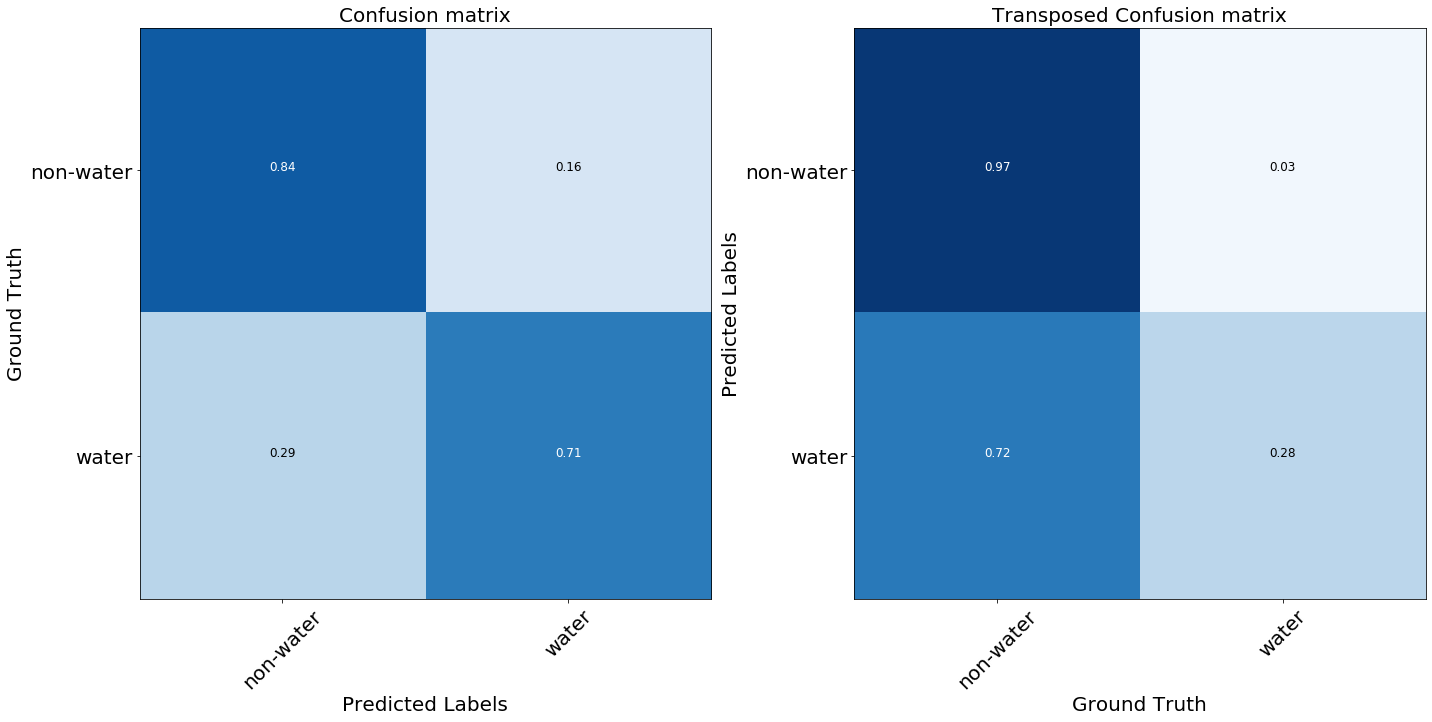

In [45]:
ig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
conf_matrix_gbm = metrics.confusion_matrix(labels_test, plabels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      ylabel='Ground Truth', 
                      xlabel='Predicted Labels',
                      title='Confusion matrix');

plt.subplot(1, 2, 2)
conf_matrix_gbm = metrics.confusion_matrix(plabels_test, labels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      xlabel='Ground Truth', 
                      ylabel='Predicted Labels',
                      title='Transposed Confusion matrix');

plt.tight_layout()

#### 7. Plot dataset balance

C:\Users\Kamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


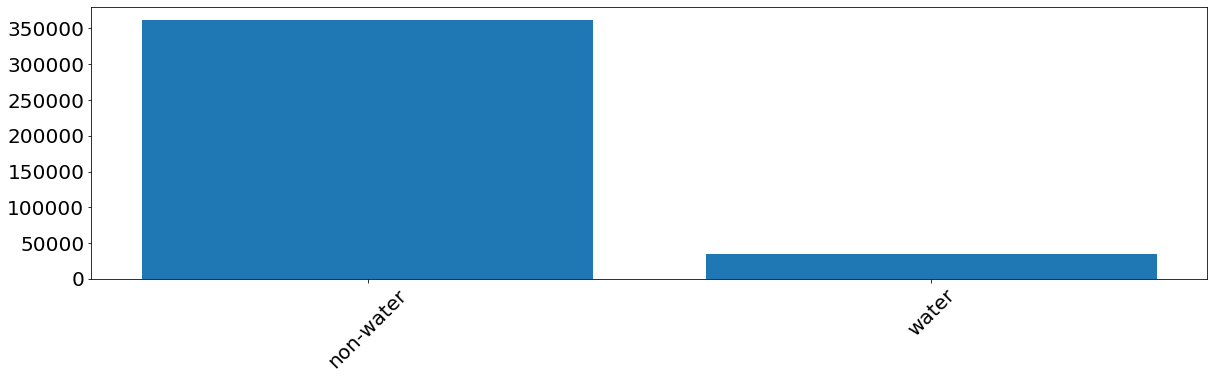

In [46]:
fig = plt.figure(figsize=(20, 5))

label_ids, label_counts = np.unique(labels_train, return_counts=True)

plt.bar(range(len(label_ids)), label_counts)
plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], rotation=45, fontsize=20);
plt.yticks(fontsize=20);

#### 8. ROC curves and AUC metrics
Calculate precision and recall rates, draw ROC curves and calculate AUC.

In [47]:
class_labels_zero_one = 1*class_labels
l_one_zero = 1*labels_test
l_one_zero.shape

(46200, 1)

In [48]:
from sklearn import preprocessing
scores_test = model.predict_proba(features_test)

labels_binarized = preprocessing.label_binarize((1*labels_test).tolist(), classes=[0, 1, 3])
labels_binarized.shape

(46200, 3)

In [49]:

fpr = dict()
tpr = dict()
roc_auc = dict()

for idx,lbl in enumerate([1, 2]):
    fpr[idx], tpr[idx], _ = metrics.roc_curve(labels_binarized[:, idx], scores_test[:, idx])
    roc_auc[idx] = metrics.auc(fpr[idx], tpr[idx])

C:\Users\Kamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  import sys


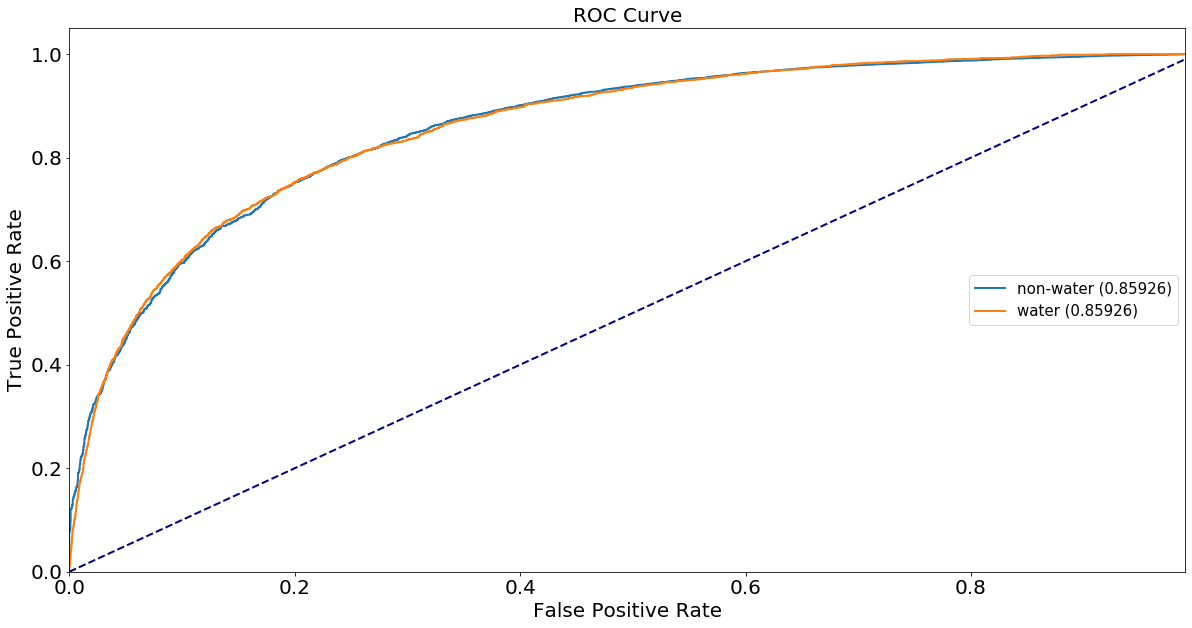

In [50]:
plt.figure(figsize=(20, 10))

for idx,lbl in enumerate(class_labels):
    if np.isnan(roc_auc[idx]):
        continue
    plt.plot(fpr[idx], tpr[idx],
         lw=2, label=class_names[lbl] + ' (%0.5f)' % roc_auc[idx])
    

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.99])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('ROC Curve', fontsize=20)
plt.legend(loc="center right", prop={'size': 15})
plt.show()

#### 9. Most important features:
Let us now check which features are most important in the above classification. The LightGBM model already contains the information about feature importances, so we only need to query them.

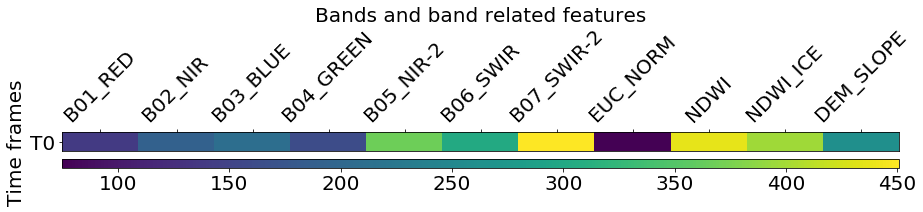

In [51]:
# names of features
fnames = ['B01_RED', 'B02_NIR', 'B03_BLUE', 'B04_GREEN', 'B05_NIR-2', 'B06_SWIR', 'B07_SWIR-2', 'EUC_NORM', 'NDWI', 'NDWI_ICE', 'DEM_SLOPE', ]

# get feature importances and reshape them to dates and features
z = model.feature_importances_.reshape((1, b))

fig = plt.figure(figsize=(15, 15))
ax = plt.gca()

# plot the importances
im = ax.imshow(z, aspect=0.25)
plt.xticks(range(len(fnames)), fnames, rotation=45, fontsize=20)
plt.yticks(range(1), ['T{}'.format(i) for i in range(1)], fontsize=20)
plt.xlabel('Bands and band related features', fontsize=20)
plt.ylabel('Time frames', fontsize=20)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# cax = fig.add_axes([0.82, 0.125, 0.04, 0.755]) 
# plt.colorbar(im, cax=cax)

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=[ax], orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)

In [52]:
model.feature_importances_

array([139, 192, 211, 163, 368, 304, 451,  75, 437, 398, 262])

#### 10. Visualization of the results

In [53]:
class PredictPatch(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature, 
    and the output names of labels and scores (optional)
    """
    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name
        
    def execute(self, eopatch):
        ftrs = eopatch[self.features_feature[0]][self.features_feature[1]]
        
        t, w, h, f = ftrs.shape
        ftrs = ftrs.reshape(t * w * h, f)
        
        plabels = self.model.predict(ftrs)
        plabels = plabels.reshape(t, w, h )
        plabels = plabels[..., np.newaxis]
        #eopatch.add_feature(FeatureType.MASK_TIMELESS, self.predicted_labels_name, plabels)
        
        if self.predicted_scores_name:
            pscores = self.model.predict_proba(ftrs)
            _, d = pscores.shape
            pscores = pscores.reshape(w, h, d)
            eopatch.add_feature(FeatureType.DATA_TIMELESS, self.predicted_scores_name, pscores)
        
        return plabels

In [54]:
eo_patch = io_utils.load_exemplary_eopatch_from_file(file='../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10/',  patch_id=6, random_choice=True)


Loaded from ../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10/3309_maxcc_0.05_x-6_y-133


In [55]:
# TASK FOR PREDICTION
predict_patch = PredictPatch(model, (FeatureType.DATA, 'DATASET_CLD_200_dil_6_str2'), 'WATER_MASK_ST_025')

predictions = []
predictions.append(predict_patch.execute(eo_patch))

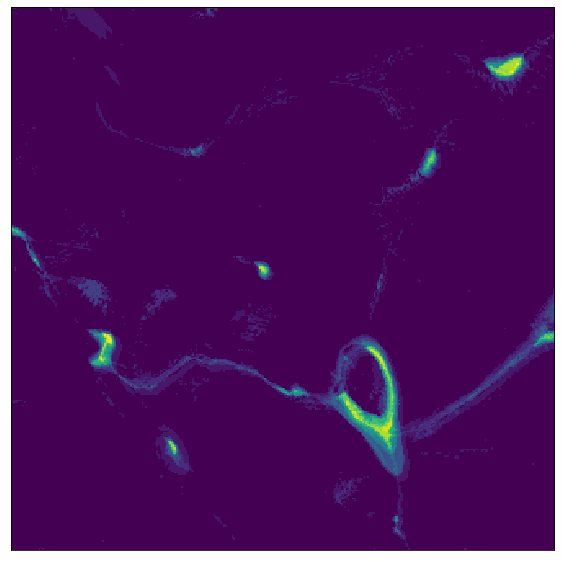

In [56]:
plot_utils.plot_timeless_mask_LANDSAT_8(eo_patch, band_idx=0, mask_acces_name='WATER_MASK_ST_025_COUNT' )

2019-07-17 00:01:03
Ploting...


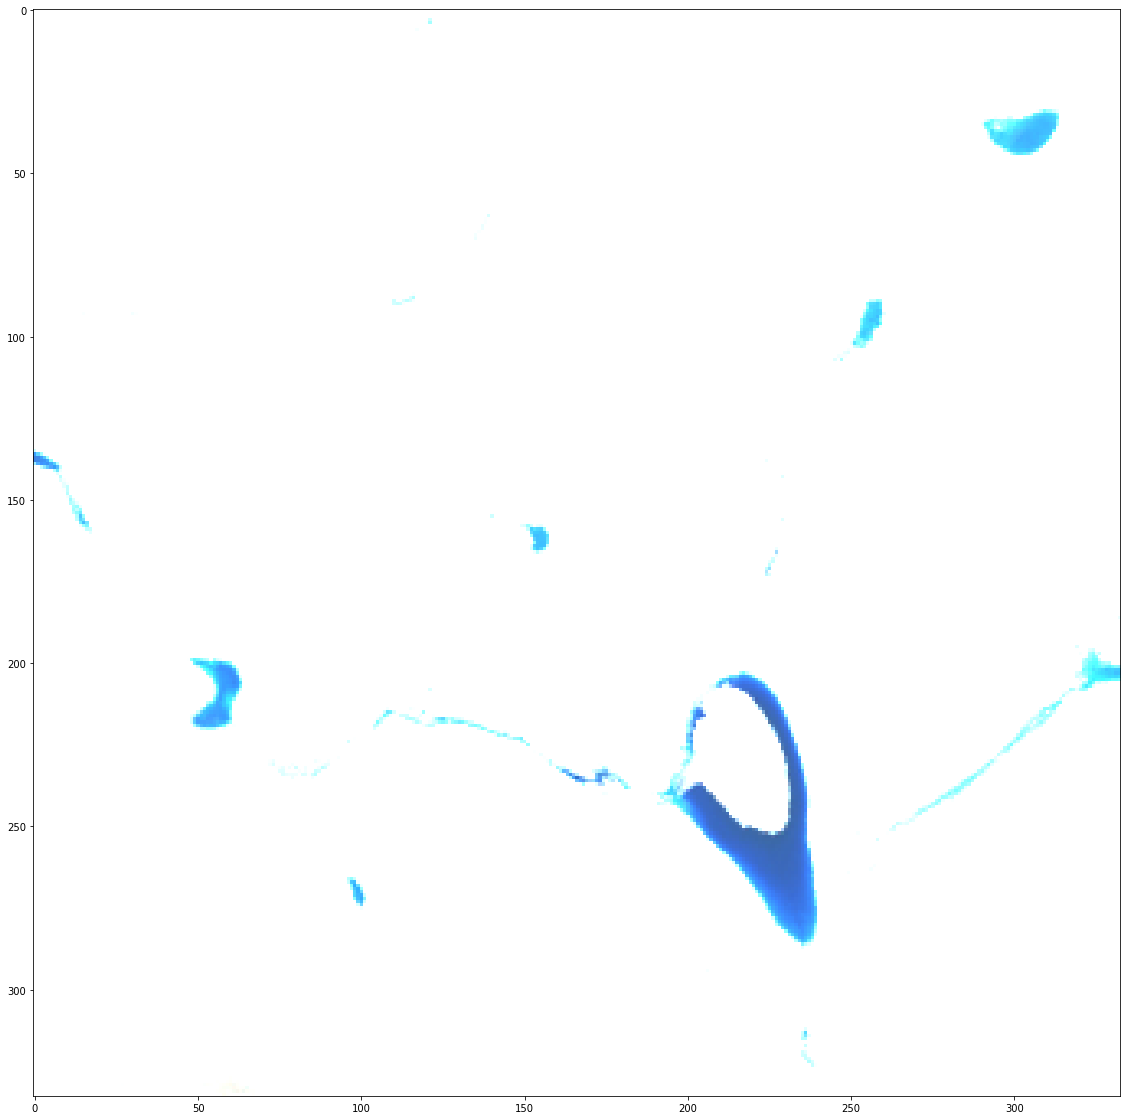

In [57]:
plot_utils.plot_RGB_LANDSAT_8_image(eo_patch, datetime_idx=15 )

2019-07-17 00:01:03
Ploting...


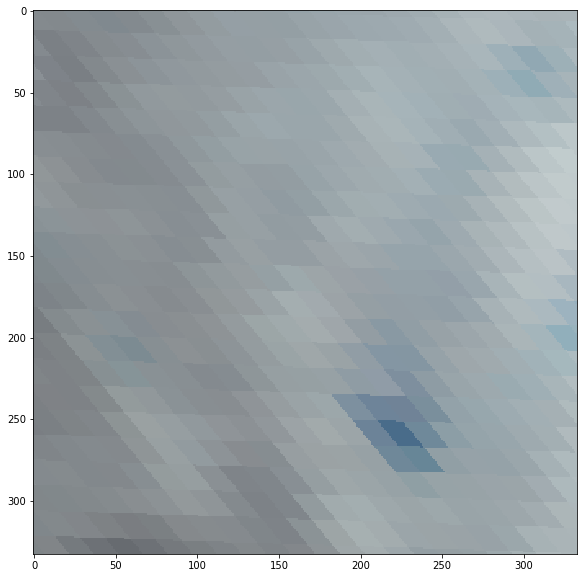

In [58]:
plot_utils.plot_RGB_MODIS_image(eo_patch, data_acces_name='MODIS_RAW_BANDS_DAY_0', datetime_idx=15)

In [59]:
patch_no = 15
reference_patch = eo_patch.mask['WATER_MASK_ST_025'][patch_no]
inspected_patch = predictions[0][patch_no]

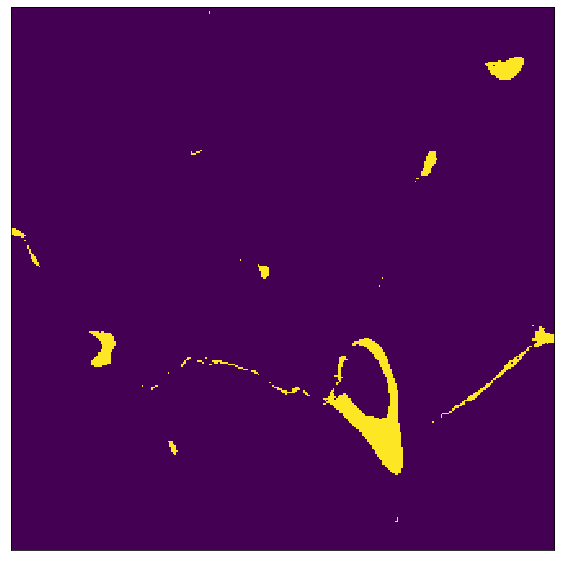

In [60]:
plot_utils.plot_matrix(reference_patch)

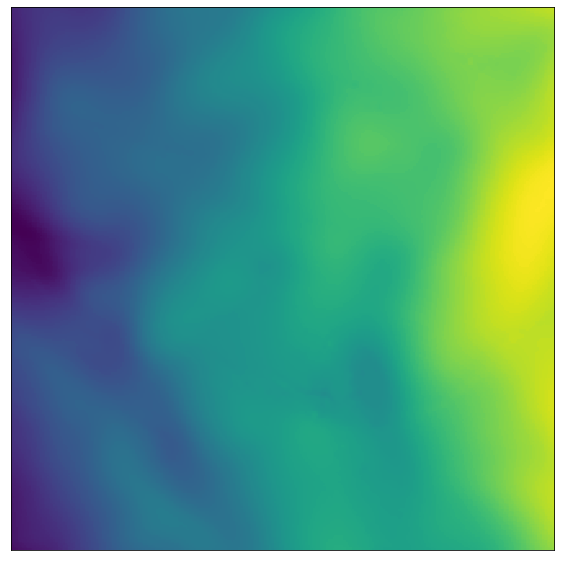

In [61]:
plot_utils.plot_matrix(eo_patch.data_timeless['DEM_RAW_LAYER'].squeeze())

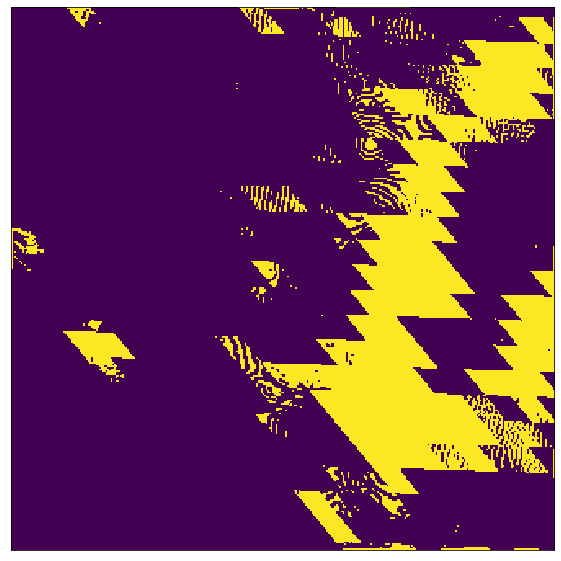

In [62]:
plot_utils.plot_matrix(inspected_patch)

In [95]:
plot_utils.plot_all_bands_in_data_acces_name(eo_patch, data_acces_name='DATASET_CLD_200_dil_6_str2', datetime_idx=15)

AttributeError: module 'utils.plot_functions' has no attribute 'plot_all_bands_in_data_acces_name'